# Question Answering

## Overview

Recall the overall workflow for retrieval augmented generation (RAG):

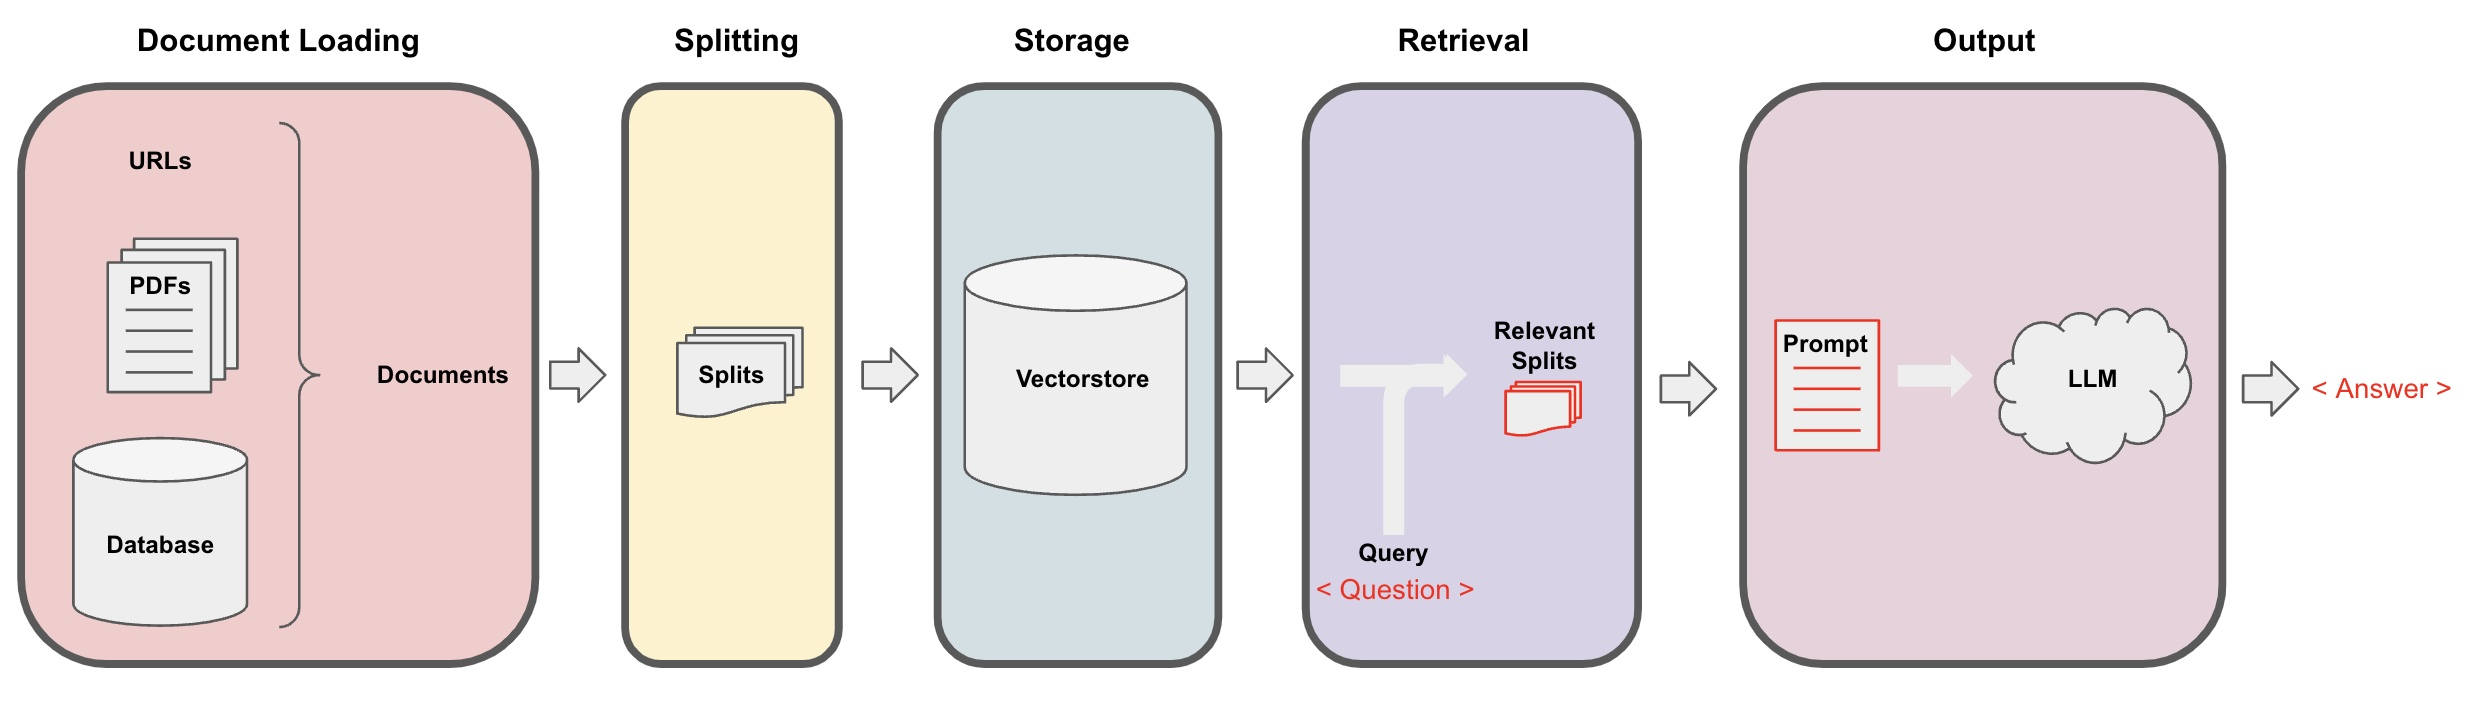

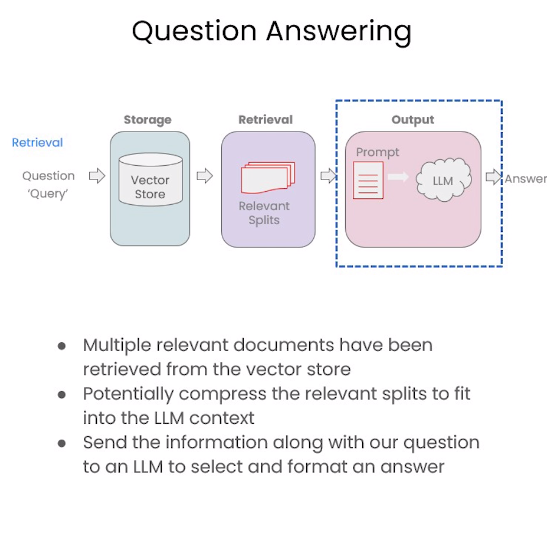

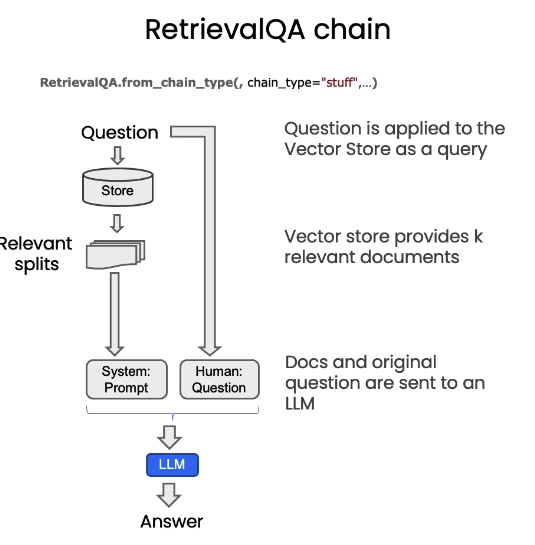

We discussed `Document Loading` and `Splitting` as well as `Storage` and `Retrieval`.

Let's load our vectorDB. 

In [1]:
import os
import openai
import sys
sys.path.append('../..')

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

openai.api_key  = os.environ['OPENAI_API_KEY']

The code below was added to assign the openai LLM version filmed until it is deprecated, currently in Sept 2023. 
LLM responses can often vary, but the responses may be significantly different when using a different model version.

In [2]:
import datetime
current_date = datetime.datetime.now().date()
if current_date < datetime.date(2023, 9, 2):
    llm_name = "gpt-3.5-turbo-0301"
else:
    llm_name = "gpt-3.5-turbo"
print(llm_name)

gpt-3.5-turbo


In [3]:
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings
persist_directory = 'docs/chroma/'
embedding = OpenAIEmbeddings()
vectordb = Chroma(persist_directory=persist_directory, embedding_function=embedding)

In [4]:
print(vectordb._collection.count())

209


In [5]:
question = "What are major topics for this class?"
docs = vectordb.similarity_search(question,k=3)
len(docs)

3

In [6]:
from langchain.chat_models import ChatOpenAI
llm = ChatOpenAI(model_name=llm_name, temperature=0) # 0 - good for factual questions

### RetrievalQA chain

In [7]:
from langchain.chains import RetrievalQA

In [8]:
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever()
)

In [9]:
result = qa_chain({"query": question})

In [10]:
result["result"]

'The major topics for this class seem to include machine learning, statistics, and algebra. Additionally, there will be discussions on extensions of the material covered in the main lectures.'

### Prompt

In [11]:
from langchain.prompts import PromptTemplate

# Build prompt
template = """Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer. Use three sentences maximum. Keep the answer as concise as possible. Always say "thanks for asking!" at the end of the answer. 
{context}
Question: {question}
Helpful Answer:"""
QA_CHAIN_PROMPT = PromptTemplate.from_template(template)


In [12]:
# Run chain
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

In [13]:
question = "Is probability a class topic?"

In [14]:
result = qa_chain({"query": question})

In [15]:
result["result"]

'Yes, probability is a class topic assumed to be familiar to students, as mentioned by the instructor. Thanks for asking!'

In [16]:
result["source_documents"][0]

Document(page_content="of this class will not be very program ming intensive, although we will do some \nprogramming, mostly in either MATLAB or Octa ve. I'll say a bit more about that later.  \nI also assume familiarity with basic proba bility and statistics. So most undergraduate \nstatistics class, like Stat 116 taught here at Stanford, will be more than enough. I'm gonna \nassume all of you know what ra ndom variables are, that all of you know what expectation \nis, what a variance or a random variable is. And in case of some of you, it's been a while \nsince you've seen some of this material. At some of the discussion sections, we'll actually \ngo over some of the prerequisites, sort of as  a refresher course under prerequisite class. \nI'll say a bit more about that later as well.  \nLastly, I also assume familiarity with basi c linear algebra. And again, most undergraduate \nlinear algebra courses are more than enough. So if you've taken courses like Math 51, \n103, Math 113 or 

### RetrievalQA chain types - `map reduce`, `refine` and `map rerank`

In [17]:
qa_chain_mr = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    chain_type="map_reduce"
)

In [18]:
result = qa_chain_mr({"query": question})

In [19]:
result["result"]

'Yes, probability is a class topic mentioned in the text.'

If you wish to experiment on the `LangChain plus platform`:

 * Go to [langchain plus platform](https://www.langchain.plus/) and sign up
 * Create an API key from your account's settings
 * Use this API key in the code below   
 * uncomment the code  
 Note, the endpoint in the video differs from the one below. Use the one below.

In [20]:
#import os
#os.environ["LANGCHAIN_TRACING_V2"] = "true"
#os.environ["LANGCHAIN_ENDPOINT"] = "https://api.langchain.plus"
#os.environ["LANGCHAIN_API_KEY"] = "..." # replace dots with your api key

In [21]:
qa_chain_mr = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    chain_type="map_reduce"
)
result = qa_chain_mr({"query": question})
result["result"]

'Yes, probability is a class topic mentioned in the text. The instructor assumes familiarity with basic probability and statistics, stating that most undergraduate statistics classes, like Stat 116 taught at Stanford, will be more than enough for the course.'

In [22]:
qa_chain_mr = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    chain_type="refine"
)
result = qa_chain_mr({"query": question})
result["result"]

'The additional context provided does not directly impact the original answer regarding probability being a class topic. The original answer still accurately addresses the question by confirming that probability is indeed a class topic that will be covered in the course. Probability is essential in understanding and developing classification algorithms in machine learning, and the instructor will use a probabilistic interpretation to derive the next learning algorithm. The discussion sections may also cover statistics and algebra as refreshers, but the main focus remains on probability in the context of machine learning.'

### RetrievalQA limitations
 
QA fails to preserve conversational history.

In [23]:
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever()
)

In [24]:
question = "Is probability a class topic?"
result = qa_chain({"query": question})
result["result"]

'Yes, probability is a class topic in the course being described. The instructor assumes familiarity with basic probability and statistics.'

In [ ]:
question = "why are those prerequesites needed?"
result = qa_chain({"query": question})
result["result"]

Note, The LLM response varies. Some responses **do** include a reference to probability which might be gleaned from referenced documents. The point is simply that the model does not have access to past questions or answers, this will be covered in the next section.